## Obtaining the predictors
This notebook is ffor showing how to extract predictive data in a systematic sample that covers all Mexico.
It outputs a csv with the coordinates of the grid and the different covariates that includes, Environmental and Population and LandUse.
In this case we will bring all the variables to start working with everything.


In [1]:
%matplotlib inline
import sys
sys.path.append('/apps')
import django
django.setup()
from drivers.tree_builder import TreeNeo
from drivers.graph_models import TreeNode, Order, Family, graph,Kingdom,Occurrence
from drivers.graph_models import Cell,Mex4km, countObjectsOf
from drivers.graph_models import pickNode
import matplotlib.pyplot as plt
import pandas as pd
import itertools as it
import numpy as np

## Use the ggplot style
plt.style.use('ggplot')

In [2]:
from raster_api.tools import RasterData
from raster_api.models import raster_models_dic as models


In [3]:
from sketches.models import Country
from mesh.models import MexMesh

Mexico = Country.objects.filter(name__contains="exico").get()
mexican_cells = MexMesh.objects.filter(cell__intersects=Mexico.geom)

### Obtaining everything

In [4]:
datadict = { key : RasterData(models[key],border=Mexico.geom) for key,value in models.iteritems()}

In [5]:
#from django.db import connections
#connections.close_all()

In [6]:
## Without resamling (whole data)
pixel_size = 0.25
%time datacube_field = map(lambda raster : raster.rescale(pixel_size),datadict.itervalues())
datacube = datacube_field

CPU times: user 316 ms, sys: 8 ms, total: 324 ms
Wall time: 4min 32s


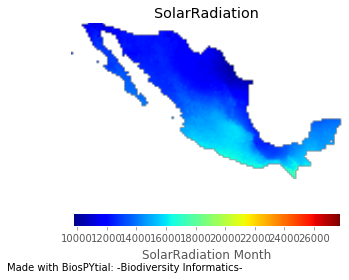

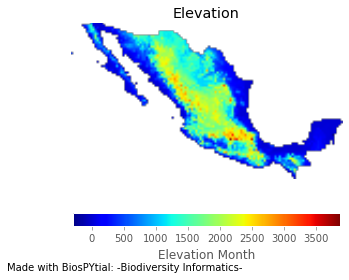

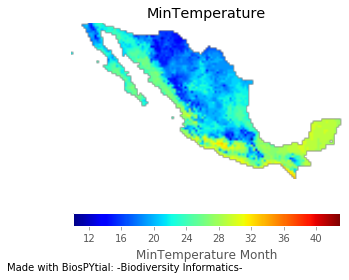

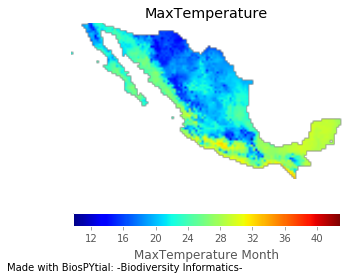

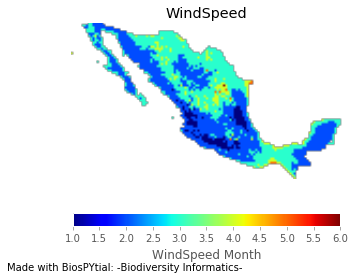

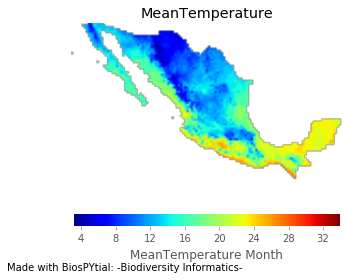

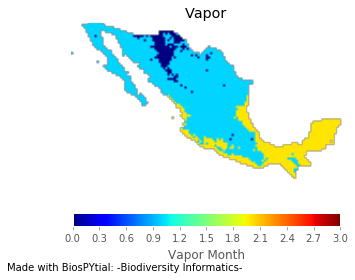

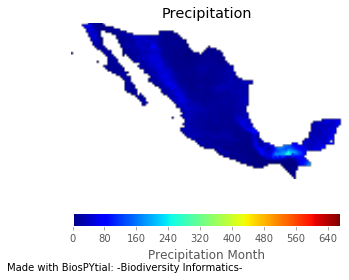

[None, None, None, None, None, None, None, None]

In [7]:
map(lambda (k,d) : d.display_field(title=k,origin='Lower'),datadict.iteritems())

## For the moment we don't want to do temporal analysis so we need to aggregate the array by the mean.

Using the new 'resample' method

In [8]:
# Take mean of everything
cubes = map(lambda (k,v): np.mean(v.toNumpyArray(),axis=0), datadict.iteritems())

The coordinates are the same so, we can extract the them with getCoordinates and then append everything as a flat array

In [9]:
coords = map(lambda (k,v) : v.getCoordinates(),datadict.iteritems())

In [10]:
coords = pd.concat(coords,axis=1)

In [11]:
coords1 = coords[[0,1]]

In [12]:
## Oke I need a way to extract the dataframe, maybe aggregate it by mean 
dataframe_cube = map(lambda cube: pd.DataFrame(cube.flatten()),cubes)

In [13]:
datacube = pd.concat(dataframe_cube,axis=1)

In [14]:
datacube = pd.concat([datacube,coords1],axis=1)

In [15]:
datacube.columns = datadict.keys() + list(coords1.columns)

In [16]:
datacube_clean = datacube.dropna()

In [17]:
## Convert to geopandas
from external_plugins.spystats.spystats import tools as tl
datacube_clean = tl.toGeoDataFrame(datacube_clean,xcoord_name='Longitude',ycoord_name='Latitude')

/apps/external_plugins/spystats/spystats/tools.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data['geometry'] = data.apply(lambda z : Point(z[xcoord_name], z[ycoord_name]), axis=1)


In [18]:
## Save the dataframe. I haven't done that.

In [19]:
coords.shape

(9271, 16)

In [20]:
coords = coords1.values

In [21]:
from traversals import strategies as st

In [22]:
points = st.CoordinatesDataFrameToPointsGeometry(coords1)

In [23]:
from raster_api.models import WorldPopLatam2010
people = RasterData(WorldPopLatam2010,Mexico.geom)

In [24]:
counts_people = map(lambda p : people.getValue(p).pop(),points)

In [25]:
oke = pd.DataFrame({'Population' : counts_people})

In [26]:
new_oke = oke.dropna()

In [27]:
new_oke.shape

(2869, 1)

In [28]:
## Just save for now
datacube2 = pd.concat([datacube,oke],axis=1)

In [29]:
datacube2.columns = datadict.keys() + list(coords1.columns) + list(oke.columns)

In [30]:
## Just save for now
datacube2.to_csv("/outputs/predicted_data_with_pop.csv")

## Now, let's extract with vector data

In [31]:
from ecoregions.models import TerrEcoregions,InegiIV
cosas = map(lambda p : TerrEcoregions.objects.filter(geom__intersects=p),points)
values = map(lambda q : q.values_list('wwf_mhtnum','wwf_mhtnam'),cosas)

## Change the records into a pandas dataframe

In [53]:
vals = [r.get() if r.exists() else (np.nan,np.nan) for r in values ]

In [57]:
dd = pd.DataFrame(vals)
dd.columns = ['vegid','vegname']

In [58]:
dd

vegid                                vegname
0       NaN                                    NaN
1       NaN                                    NaN
2       NaN                                    NaN
3       NaN                                    NaN
4       NaN                                    NaN
5       NaN                                    NaN
6       NaN                                    NaN
7       NaN                                    NaN
8       NaN                                    NaN
9       NaN                                    NaN
10      NaN                                    NaN
11      NaN                                    NaN
12      NaN                                    NaN
13      NaN                                    NaN
14      NaN                                    NaN
15      NaN                                    NaN
16      NaN                                    NaN
17      NaN                                    NaN
18      NaN                                    NaN
19      NaN                                    NaN
20      NaN                                    NaN
21      NaN                                    NaN
22      NaN                                    NaN
23      NaN                                    NaN
24      NaN                                    NaN
25      NaN                                    NaN
26      NaN                                    NaN
27      NaN                                    NaN
28      NaN                                    NaN
29      NaN                                    NaN
...     ...                                    ...
9241    5.0              Temperate Conifer Forests
9242    5.0              Temperate Conifer Forests
9243    5.0              Temperate Conifer Forests
9244    5.0              Temperate Conifer Forests
9245    5.0              Temperate Conifer Forests
9246    5.0              Temperate Conifer Forests
9247    5.0              Temperate Conifer Forests
9248    5.0              Temperate Conifer Forests
9249    5.0              Temperate Conifer Forests
9250    4.0  Temperate Broadleaf and Mixed Forests
9251    4.0  Temperate Broadleaf and Mixed Forests
9252    4.0  Temperate Broadleaf and Mixed Forests
9253    4.0  Temperate Broadleaf and Mixed Forests
9254    4.0  Temperate Broadleaf and Mixed Forests
9255    4.0  Temperate Broadleaf and Mixed Forests
9256    4.0  Temperate Broadleaf and Mixed Forests
9257    4.0  Temperate Broadleaf and Mixed Forests
9258    4.0  Temperate Broadleaf and Mixed Forests
9259    4.0  Temperate Broadleaf and Mixed Forests
9260    4.0  Temperate Broadleaf and Mixed Forests
9261    4.0  Temperate Broadleaf and Mixed Forests
9262    4.0  Temperate Broadleaf and Mixed Forests
9263    4.0  Temperate Broadleaf and Mixed Forests
9264    4.0  Temperate Broadleaf and Mixed Forests
9265    4.0  Temperate Broadleaf and Mixed Forests
9266    4.0  Temperate Broadleaf and Mixed Forests
9267    4.0  Temperate Broadleaf and Mixed Forests
9268    4.0  Temperate Broadleaf and Mixed Forests
9269    4.0  Temperate Broadleaf and Mixed Forests
9270    4.0  Temperate Broadleaf and Mixed Forests

[9271 rows x 2 columns]

In [59]:
datacube3 = pd.concat([datacube2,dd],axis=1)

In [60]:
datacube3[:10]

SolarRadiation  Elevation  MinTemperature  MaxTemperature  WindSpeed  \
0             NaN        NaN             NaN             NaN        NaN   
1             NaN        NaN             NaN             NaN        NaN   
2             NaN        NaN             NaN             NaN        NaN   
3             NaN        NaN             NaN             NaN        NaN   
4             NaN        NaN             NaN             NaN        NaN   
5             NaN        NaN             NaN             NaN        NaN   
6             NaN        NaN             NaN             NaN        NaN   
7             NaN        NaN             NaN             NaN        NaN   
8             NaN        NaN             NaN             NaN        NaN   
9             NaN        NaN             NaN             NaN        NaN   

   MeanTemperature  Vapor  Precipitation   Longitude  Latitude  Population  \
0              NaN    NaN            NaN -118.408333    14.475         NaN   
1              NaN    NaN            NaN -118.158333    14.475         NaN   
2              NaN    NaN            NaN -117.908333    14.475         NaN   
3              NaN    NaN            NaN -117.658333    14.475         NaN   
4              NaN    NaN            NaN -117.408333    14.475         NaN   
5              NaN    NaN            NaN -117.158333    14.475         NaN   
6              NaN    NaN            NaN -116.908333    14.475         NaN   
7              NaN    NaN            NaN -116.658333    14.475         NaN   
8              NaN    NaN            NaN -116.408333    14.475         NaN   
9              NaN    NaN            NaN -116.158333    14.475         NaN   

   vegid vegname  
0    NaN     NaN  
1    NaN     NaN  
2    NaN     NaN  
3    NaN     NaN  
4    NaN     NaN  
5    NaN     NaN  
6    NaN     NaN  
7    NaN     NaN  
8    NaN     NaN  
9    NaN     NaN

In [61]:
datacube3.to_csv("/outputs/predicted_data_with_pop_veg.csv")